In [40]:
%matplotlib inline

import future
import pylab as plt
import numpy as np
from scipy.spatial import cKDTree
from bornagain import Molecule
from thor import scatter

In [41]:
def plot_dens(dens, grid_size, **kwargs):
    plt.figure(figsize=(16,12))
    extent = (-grid_size/2, grid_size/2, grid_size/2, -grid_size/2)
    plt.subplot(131);plt.imshow( np.sum( dens, axis=2), extent=extent, **kwargs);plt.title("view along x-y");plt.ylabel('Angstrom')
    plt.subplot(132);plt.imshow( np.sum( dens, axis=1), extent=extent, **kwargs);plt.title("view along x-z");plt.xlabel('Angstrom')
    plt.subplot(133);plt.imshow( np.sum( dens, axis=0),extent=extent, **kwargs);plt.title("view along y-z")

make grid
make coors
make tree
subtract


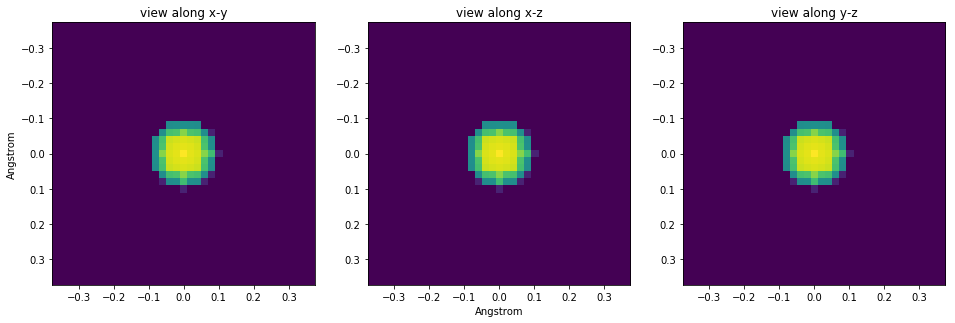

In [42]:

# single atom densities
#====================

# define a grid around a single atom
grid_size = 0.75 # angstrom
grid_spacing = 0.02 # angstrom
Ngrid_pt = grid_size/grid_spacing

print("make grid")

x,y,z = np.mgrid[
        -grid_size/2.:grid_size/2.:Ngrid_pt*1j, 
        -grid_size/2.:grid_size/2.:Ngrid_pt*1j, 
        -grid_size/2.:grid_size/2.:Ngrid_pt*1j]


print("make coors")
coors = np.array( zip(x.ravel(), y.ravel(), z.ravel() ))
print("make tree")
KD_grid = cKDTree(coors)

single_atom = np.zeros(x.shape)
lucky_atom = 2
distances, grid_pos =KD_grid.query( [0,0,0], k=500, distance_upper_bound=3.5)
n_neighbors = len([ d for d in distances if d != np.inf])
distances, grid_pos = distances[:n_neighbors],  grid_pos[:n_neighbors]

grid_idx = np.unravel_index( grid_pos, single_atom.shape)

form_fact = scatter.atomic_electrondens( lucky_atom, distances )

single_atom[grid_idx] += form_fact

plot_dens( single_atom, grid_size, vmax=70)


In [72]:
# protein densities

# define a grid
grid_size = 55 # angstrom
grid_spacing = 0.25 # angstrom
Ngrid_pt = grid_size/grid_spacing

# load a molecule
mol = Molecule("2LYZ.pdb")
mol.atom_vecs -= mol.atom_vecs.mean(0)
mol.atom_vecs *= 1e10



print("make grid")

x,y,z = np.mgrid[
        -grid_size/2.:grid_size/2.:Ngrid_pt*1j, 
        -grid_size/2.:grid_size/2.:Ngrid_pt*1j, 
        -grid_size/2.:grid_size/2.:Ngrid_pt*1j]


print("make coors")
coors = np.array( zip(x.ravel(), y.ravel(), z.ravel() ))
print("make tree")
KD_grid = cKDTree(coors)



make grid
make coors
make tree


In [90]:
# density nearest neighbor mapping
def density_nearest(atom_size):
    nearest_gridpts_to_atoms = KD_grid.query_ball_point( mol.atom_vecs, r=atom_size)
    dens = np.zeros( x.shape)
    for i,nearest in enumerate( nearest_gridpts_to_atoms):
        if not nearest:
            continue
        idx = np.unravel_index( nearest, x.shape)
        dens[idx] += mol.Z[i]
    return dens

dens1 = density_nearest(0.5)
dens2 = density_nearest(1.5)
dens3 = density_nearest(3)



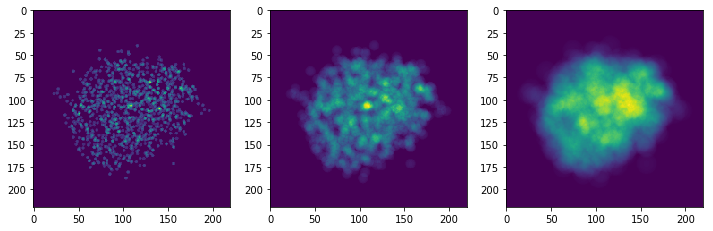

In [91]:

plt.figure(figsize=(12,12))
plt.subplot( 131);plt.imshow( dens1.mean(0))
plt.subplot( 132);plt.imshow( dens2.mean(0))
plt.subplot( 133);plt.imshow( dens3.mean(0))

In [92]:
%%time
from scipy.fftpack import fftn, fftshift, fftfreq
def diffract_nearest(dens):
    Nfft = dens.shape[0]*2
    diffrac = np.abs(fftshift(fftn(dens, shape=[Nfft,Nfft,Nfft])))**2
    return diffrac

difr1 = diffract_nearest(dens1)
difr2 = diffract_nearest(dens2)
difr3 = diffract_nearest(dens3)

/Users/damende/miniconda2/lib/python2.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


CPU times: user 22.1 s, sys: 7.37 s, total: 29.5 s
Wall time: 31.3 s


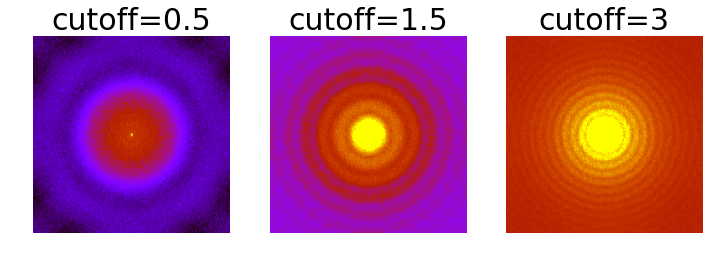

In [104]:
# DIFFRACTION!
plt.figure(figsize=(12,12))

fs=30
opt = {'norm':plt.mpl.colors.LogNorm(), 'cmap':'gnuplot'}
plt.subplot( 131);plt.imshow( difr1.mean(0), **opt)
plt.title("cutoff=0.5", fontsize=fs)
plt.axis("off")
plt.subplot( 132);plt.imshow( difr2.mean(0), **opt)
plt.title("cutoff=1.5", fontsize=fs)
plt.axis("off")

plt.subplot( 133);plt.imshow( difr3.mean(0), **opt)
_=plt.title("cutoff=3", fontsize=fs)
_=plt.axis("off")
